In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Getting started with the Vertex AI Gemini 1.5 Pro For Image Recognition


<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/getting-started/intro_gemini_1_5_pro.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fgetting-started%2Fintro_gemini_1_5_pro.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/getting-started/intro_gemini_1_5_pro.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/getting-started/intro_gemini_1_5_pro.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>


## Overview

Gemini 1.5 Pro is a new language model from the Gemini family. This model introduces a breakthrough long context window of up to 1 million tokens that can help seamlessly analyze large amounts of information and long-context understanding. It can process text, images, audio, video, and code all together for deeper insights. Learn more about [Gemini 1.5](https://blog.google/technology/ai/google-gemini-next-generation-model-february-2024/).

With this tutorial, you learn how to use the Vertex AI Gemini API and the Vertex AI SDK to work with the Gemini 1.5 Pro model to:

- analyze audio for insights.
- understand videos (including their audio components).
- extract information from PDF documents.
- process images, video, audio, and text simultaneously.

## Getting Started

### Install Vertex AI SDK for Python

In [1]:
! pip3 install --upgrade --user --quiet google-cloud-aiplatform

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

In [2]:
import sys

if "google.colab" in sys.modules:
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [9]:
!gcloud config set project jc-gcp-project

Updated property [core/project].


In [10]:
import os
import base64
import vertexai
import json
import time

PROJECT_ID = "jc-gcp-project"
LOCATION = "us-central1"
BUCKET = "jc-gcp-project-01"


FLASH_MODEL_ID = "gemini-1.5-flash-002"
PRO_MODEL_ID = "gemini-1.5-pro-002"
FLAHSH2_MODEL_ID = "gemini-2.0-flash-exp"
FLAHSH2_INF_MODEL_ID = "gemini-2.0-flash-thinking-exp-1219"

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [11]:
import IPython.display
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    HarmBlockThreshold,
    HarmCategory,
    Part,
)

In [12]:
flash_model = GenerativeModel(FLASH_MODEL_ID)
pro_model = GenerativeModel(PRO_MODEL_ID)
flash_2_model = GenerativeModel(FLAHSH2_MODEL_ID)
flash_2_inf_model = GenerativeModel(FLAHSH2_INF_MODEL_ID)

## Check Samsung Feedback

이미지만 입력한경우
이미지+제목

의 경우 100% 오답이나오고

이미지+제목+출연자리스트까지 입력했을때

9개 기준 4번, 9번 이미지를 김희원->엄태구 로 인식하네요

기존에 장도연을 인식 못하는 건 개선 되었습니다

## Replicate the issue - 9번 이미지 오류 확인 (정답: 김희원, 판별: 엄태구)

In [60]:
import io
from PIL import Image
from IPython import display
from google.cloud import storage
import matplotlib.pyplot as plt
import tensorflow as tf

def showImage(gcs_uri):
    """
    GCS URI를 입력으로 받아 이미지를 표시하는 함수

    Args:
        gcs_uri: GCS에 저장된 이미지의 URI (예: 'gs://bucket-name/image.jpg')
    """
    
    f = tf.io.gfile.GFile(gcs_uri, 'rb')
    stream = io.BytesIO(f.read())
    img = Image.open(stream)

    plt.figure(figsize=(10, 5))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [ ]:
# #### Check Sample IMG
# # Replace these with your values
# BUCKET_NAME = "jc-gcp-project-01"
# # BLOB_NAME = "image_recognition/Screenshot 2024-11-21 at 9.33.23 AM.png"
# BLOB_NAME = "image_recognition/salon_drip_9.png"
# image_file_uri = f"gs://{BUCKET_NAME}/{BLOB_NAME}"

# showImage(image_file_uri)

In [63]:
def generate(prompt:str,
             video_uri:str,
             response_schema)->str:
    """
    Function to call Gemini for Transcription and Translation.

    Args:
    prompt: 사진속 인물 이름을 정확히 찾아서 알려줘.
    yt_uri: Youtube video URI to analyze.

    Returns:
    A transcription or translation with specified response schema.(JSON)

    """

    from vertexai.generative_models import (
          Part,
          SafetySetting,
          GenerationConfig
    )

    # Configuration to contorl LLM generation.
    generation_config = GenerationConfig(
        max_output_tokens = 8192,
        temperature=0,
        top_p =0.95,
        response_mime_type="application/json",
        response_schema=response_schema
    )

    # Sate setting
    safety_settings = [
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_HARASSMENT,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
    ]

    image1 = Part.from_uri(
        mime_type="image/jpeg",
        uri=video_uri,
    )

    responses = flash_2_model.generate_content(
        [prompt, image1],
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=False,
    )
  
    return responses.text

In [ ]:
# #### Test IMG + Gemini 
# prompt_transcript = """
#  {Title : Who Said Um Tae-goo was Quiet? | Salon Drip2,
#  Cast: Jang Do Yeon, Kim Hie Won, Um Tae-goo, Kim Seolhyun}
# Title과 Cast 정보를 참고해서 대답해 주세요. 첨부된 Image 속 인물이 누군지 알려주세요.
# 안경 등 인물의 생김새 특징을 잘 살펴보고 이름을 알려주세요."""

# image_file_uri = f"gs://{BUCKET_NAME}/{BLOB_NAME}"

# # Response schema can control the output of generation from Gemini.
# response_schema = {
#                 "type": "ARRAY",
#                 "items": {
#                     "type": "STRING",
#                 },
#             }

# showImage(image_file_uri)
# json_str = generate(prompt_transcript, image_file_uri, response_schema)
# json_transcript = json.loads(json_str)
# print(json_transcript)

image_recognition/salon_drip_1.png


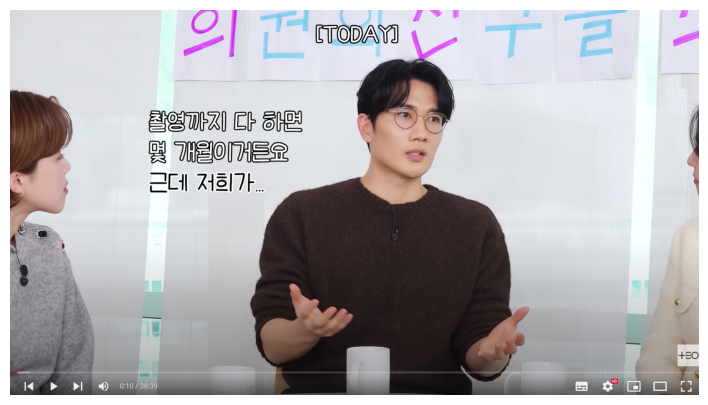

['{"name": "Um Tae-goo", "face_shape": "oval", "eyebrow_shape": "straight", "nose_shape": "straight", "lip_shape": "thin", "hair_style": "black, short, parted", "skin_color": "light"}', '{"name": "Jang Do Yeon", "face_shape": "round", "eyebrow_shape": "arched", "nose_shape": "round", "lip_shape": "full", "hair_style": "brown, short, bob", "skin_color": "light"}', '{"name": "Kim Seolhyun", "face_shape": "oval", "eyebrow_shape": "arched", "nose_shape": "straight", "lip_shape": "full", "hair_style": "black, long, straight", "skin_color": "light"}']

image_recognition/salon_drip_10.png


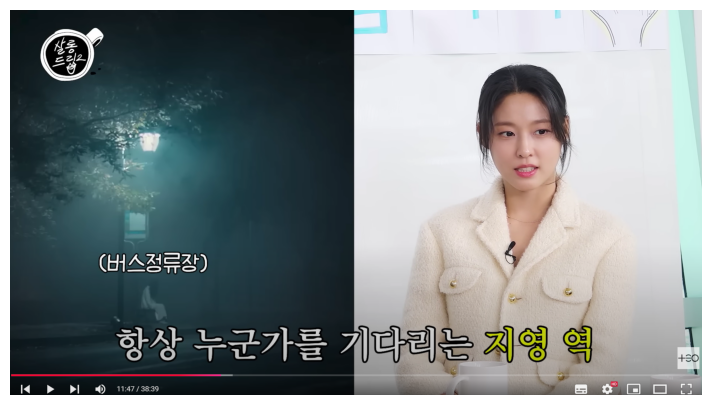

['Kim Seolhyun']

image_recognition/salon_drip_2.png


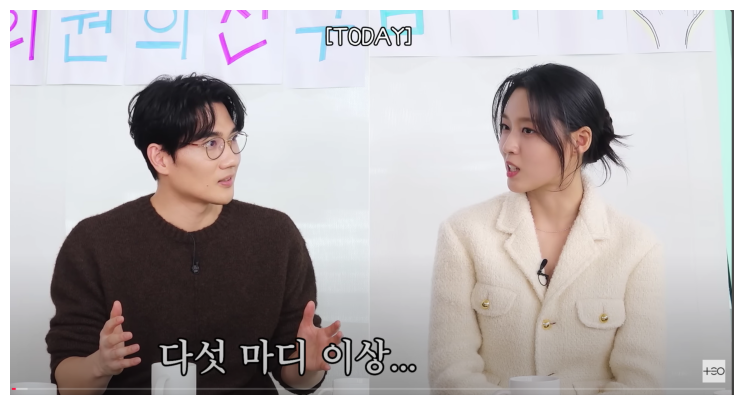

['{"person": "Um Tae-goo", "face_shape": "oval", "eyebrows": "straight", "nose": "pointed", "lips": "thin", "hair": "black, short, parted", "skin_tone": "light"}', '{"person": "Kim Seolhyun", "face_shape": "oval", "eyebrows": "arched", "nose": "pointed", "lips": "full", "hair": "black, tied back", "skin_tone": "light"}']

image_recognition/salon_drip_3.png


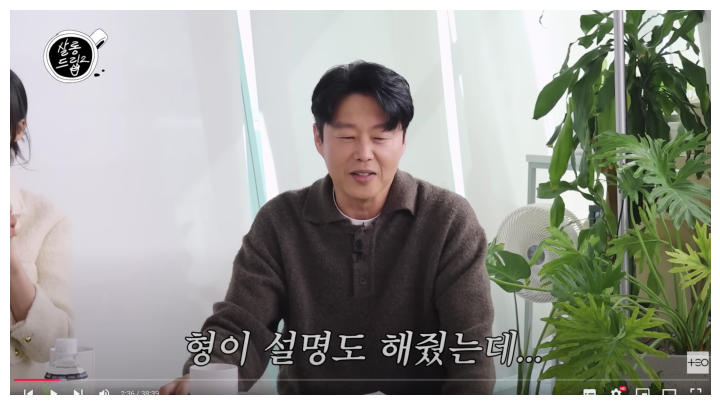

['{"name": "Kim Hie Won", "face_shape": "round", "eyebrow_shape": "straight", "nose_shape": "rounded", "lip_shape": "thin", "hair_style": "short and dark", "skin_color": "fair"}']

image_recognition/salon_drip_4.png


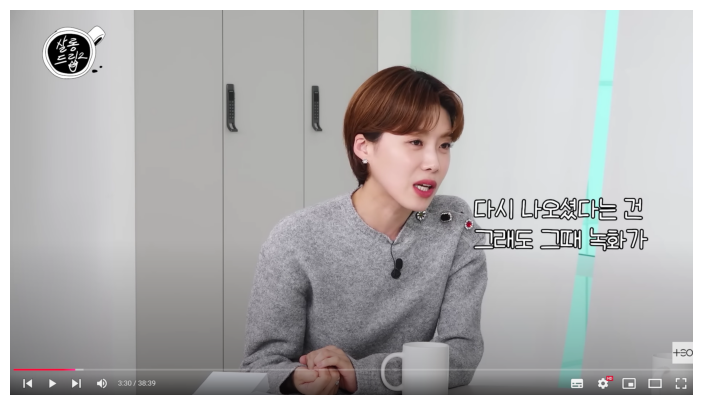

['Jang Do Yeon']

image_recognition/salon_drip_5.png


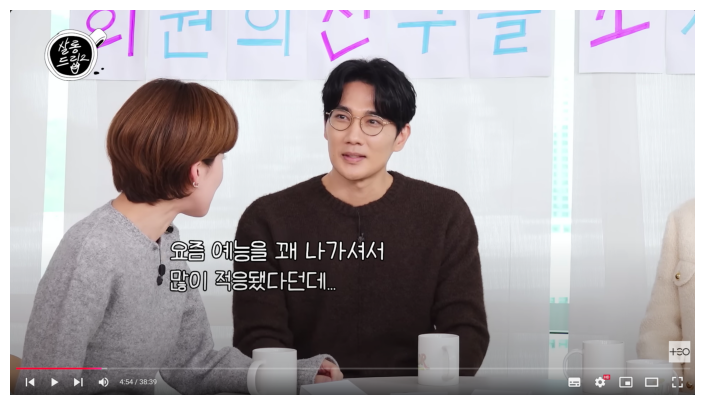

['{"person_name": "Jang Do Yeon", "face_shape": "round", "eyebrow_shape": "arched", "nose_shape": "rounded", "lip_shape": "thin", "hair_style": "short bob", "skin_tone": "fair"}', '{"person_name": "Um Tae-goo", "face_shape": "oval", "eyebrow_shape": "straight", "nose_shape": "pointed", "lip_shape": "thin", "hair_style": "short and dark", "skin_tone": "fair"}']

image_recognition/salon_drip_6.png


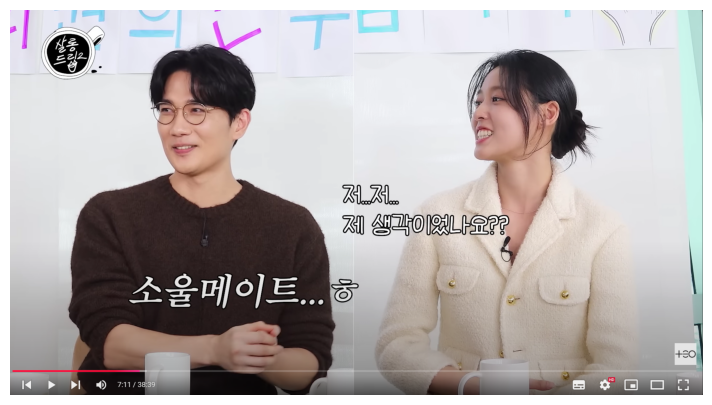

['{"person": "Um Tae-goo", "face_shape": "oval", "eyebrow_shape": "straight", "nose_shape": "straight", "lip_shape": "thin", "hair_style": "short, black, parted", "skin_color": "light"}', '{"person": "Kim Seolhyun", "face_shape": "oval", "eyebrow_shape": "arched", "nose_shape": "straight", "lip_shape": "full", "hair_style": "black, tied back", "skin_color": "light"}']

image_recognition/salon_drip_7.png


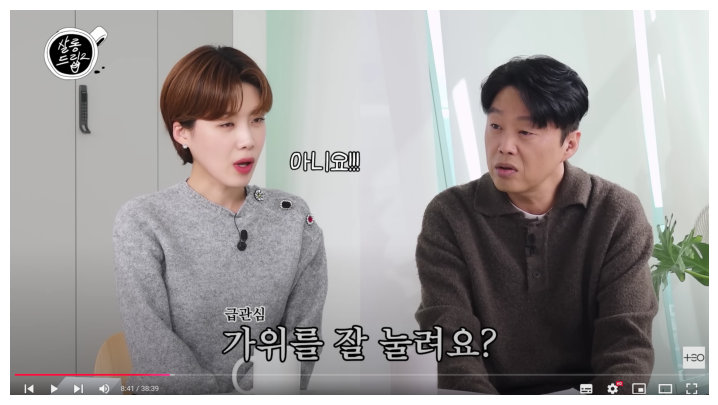

['{"name": "Jang Do Yeon", "face_shape": "round", "eyebrow_shape": "arched", "nose_shape": "rounded", "lip_shape": "full", "hair_style": "short bob", "skin_color": "fair"}', '{"name": "Kim Hie Won", "face_shape": "oval", "eyebrow_shape": "straight", "nose_shape": "wide", "lip_shape": "thin", "hair_style": "short and wavy", "skin_color": "tan"}']

image_recognition/salon_drip_8.png


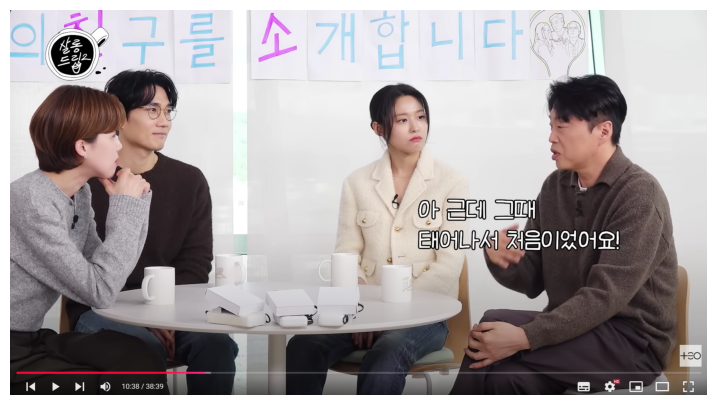

['{"name": "Jang Do Yeon", "face_shape": "round", "eyebrow_shape": "arched", "nose_shape": "rounded", "lip_shape": "full", "hair_style": "short bob", "skin_tone": "fair"}', '{"name": "Um Tae-goo", "face_shape": "oval", "eyebrow_shape": "straight", "nose_shape": "pointed", "lip_shape": "thin", "hair_style": "short black", "skin_tone": "fair"}', '{"name": "Kim Seolhyun", "face_shape": "oval", "eyebrow_shape": "arched", "nose_shape": "pointed", "lip_shape": "full", "hair_style": "long black", "skin_tone": "fair"}', '{"name": "Kim Hie Won", "face_shape": "round", "eyebrow_shape": "straight", "nose_shape": "wide", "lip_shape": "thin", "hair_style": "short black", "skin_tone": "tan"}']

image_recognition/salon_drip_9.png


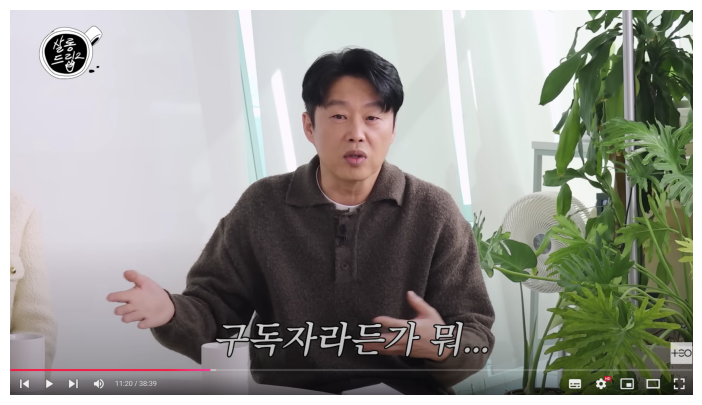

['{"name": "Um Tae-goo", "face_shape": "round", "eyebrow_shape": "straight", "nose_shape": "rounded", "lip_shape": "thin", "hair_style": "short and dark", "skin_color": "light"}']



In [66]:
### Prompt Form
prompt_transcript = """
 {Title : Who Said Um Tae-goo was Quiet? | Salon Drip2,
 Cast: Jang Do Yeon, Kim Hie Won, Um Tae-goo, Kim Seolhyun}
- Title과 Cast 정보를 참고하여, Image 속 인물의 이름과 특징을 알려주세요.
- 각 이미지 속 인물의 얼굴형, 눈썹 모양, 코 모양, 입술 모양, 헤어스타일, 피부색 등의 외모적인 특징들을 바탕으로 각 이미지 속 인물이 누구인지 정확하게 분석하세요.
- 인물의 이름은 영어로, JSON포맷으로 답변하세요.
"""

### Output Form
response_schema = {
                "type": "ARRAY",
                "items": {
                    "type": "STRING",
                },
            }

### Check Bucket(img) to run Gemini
BUCKET_NAME = "jc-gcp-project-01"
FOLDER_NAME = "image_recognition"
# List all blobs in the folder
blobs = bucket.list_blobs(prefix=FOLDER_NAME + '/')
for blob in blobs:
    if blob.name.startswith('image_recognition/salon_drip'):
        print(f"{blob.name}")
        image_file_uri = f"gs://{BUCKET_NAME}/{blob.name}"
        showImage(image_file_uri) # Show IMG
        json_str = generate(prompt_transcript, image_file_uri, response_schema) # Gemini Work
        json_transcript = json.loads(json_str)
        print(json_transcript)
        print()
        time.sleep(2)

## New Trial - 241223

## Check Captured Image with Short Video

In [99]:
def generate_2nd(prompt:str,
             image_uri:str,
             video_uri:str,
             response_schema)->str:
    """
    Function to call Gemini for Transcription and Translation.

    Args:
    prompt: 사진속 인물 이름을 정확히 찾아서 알려줘.
    yt_uri: Youtube video URI to analyze.

    Returns:
    A transcription or translation with specified response schema.(JSON)

    """

    from vertexai.generative_models import (
          Part,
          SafetySetting,
          GenerationConfig
    )

    # Configuration to contorl LLM generation.
    generation_config = GenerationConfig(
        max_output_tokens = 8192,
        temperature=1,
        top_p =0.95,
        response_mime_type="application/json",
        response_schema=response_schema
    )

    # Sate setting
    safety_settings = [
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_HARASSMENT,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
    ]

    image1 = Part.from_uri(
        mime_type="image/jpeg",
        uri=image_uri,
    )
    
    video1 = Part.from_uri(
      mime_type="video/*",
      uri=video_uri,
    )
    
    responses = flash_2_model.generate_content(
        [prompt, image1, video1],
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=False,
    )
  
    return responses.text

In [117]:
def generate_vid(prompt:str,
             video_uri:str,
             response_schema)->str:
    """
    Function to call Gemini for Transcription and Translation.

    Args:
    prompt: 사진속 인물 이름을 정확히 찾아서 알려줘.
    yt_uri: Youtube video URI to analyze.

    Returns:
    A transcription or translation with specified response schema.(JSON)

    """

    from vertexai.generative_models import (
          Part,
          SafetySetting,
          GenerationConfig
    )

    # Configuration to contorl LLM generation.
    generation_config = GenerationConfig(
        max_output_tokens = 8192,
        temperature=1,
        top_p =0.95,
        response_mime_type="application/json",
        response_schema=response_schema
    )

    # Sate setting
    safety_settings = [
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_HARASSMENT,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
    ]
    
    video1 = Part.from_uri(
      mime_type="video/*",
      uri=video_uri,
    )
    
    responses = flash_2_model.generate_content(
        [prompt, video1],
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=False,
    )
  
    return responses.text

In [122]:
def generate_img(prompt:str,
             image_uri:str,
             response_schema)->str:
    """
    Function to call Gemini for Transcription and Translation.

    Args:
    prompt: 사진속 인물 이름을 정확히 찾아서 알려줘.
    yt_uri: Youtube video URI to analyze.

    Returns:
    A transcription or translation with specified response schema.(JSON)

    """

    from vertexai.generative_models import (
          Part,
          SafetySetting,
          GenerationConfig
    )

    # Configuration to contorl LLM generation.
    generation_config = GenerationConfig(
        max_output_tokens = 8192,
        temperature=1,
        top_p =0.95,
        response_mime_type="application/json",
        response_schema=response_schema
    )

    # Sate setting
    safety_settings = [
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_HARASSMENT,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
    ]
    
    image1 = Part.from_uri(
        mime_type="image/jpeg",
        uri=image_uri,
    )
    
    responses = flash_2_model.generate_content(
        [prompt, image1],
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=False,
    )
  
    return responses.text

In [ ]:
###### Test
# # Replace these with your values
# BUCKET_NAME = "jc-gcp-project-01"
# BLOB_NAME = "image_recognition/salon_drip_9.png"

# # Input Data
# image_file_uri = f"gs://{BUCKET_NAME}/{BLOB_NAME}"
# video_clip = "gs://jc-gcp-project-us-notebooks/us-central1-a/instance-20231027-002630/sample_video/salon_drip_3min.webm"
# title_inf = "살롱드립2"

# # Show Image

# showImage(image_file_uri)
# # Prompt
# prompt_transcript = f"""
# 다음 이미지 속{image_file_uri}에 나오는 인물의 이름을 알려주세요.
# 아래 영상을 분석해서 이미지 속 인물의 정확한 이름을 확인 합니다. ({video_clip})
# """

# # Response schema
# response_schema = {
#                 "type": "ARRAY",
#                 "items": {
#                     "type": "STRING",
#                 },
#             }

# json_str = generate_2nd(prompt_transcript, image_file_uri, video_clip, response_schema)
# json_transcript = json.loads(json_str)
# print(json_transcript)

#### Video + Image At Once

In [ ]:
######## Video + Image At once
### Check Bucket(img) to run Loop
BUCKET_NAME = "jc-gcp-project-01"
FOLDER_NAME = "image_recognition"

video_clip = "gs://jc-gcp-project-us-notebooks/us-central1-a/instance-20231027-002630/sample_video/salon_drip_3min.webm"
# title_inf = "살롱드립2"


# Response schema
response_schema = {
                "type": "ARRAY",
                "items": {
                    "type": "STRING",
                },
            }

# List all blobs in the folder
blobs = bucket.list_blobs(prefix=FOLDER_NAME + '/')
for blob in blobs:
    if blob.name.startswith('image_recognition/salon_drip'):
        print(f"{blob.name}")
        image_file_uri = f"gs://{BUCKET_NAME}/{blob.name}"
        showImage(image_file_uri) # Show IMG
        
        # Prompt
        prompt_transcript = f"""
        다음 이미지 속 {image_file_uri} 인물의 이름을 알려주세요.
        
        1. 짧은 영상 {video_clip}속 등장 인물 들의 외모 특징을 분석하고 구별해서 정리 하세요.
        2. 정리 내용을 기반으로 이미지 속 인물의 실명을 알려주세요.
        3. 정답예시: ("이름":"홍길동", "이유":"빨간색 머리")
        """
        json_str = generate_2nd(prompt_transcript, image_file_uri, video_clip, response_schema) # Gemini Work
        json_transcript = json.loads(json_str)
        print(json_transcript)
        print()
        time.sleep(2)

#### Video processing FIRST,,,,, and then, Image (Gemini)

In [140]:
### Check Bucket(img) to run Loop
BUCKET_NAME = "jc-gcp-project-01"
FOLDER_NAME = "image_recognition"

video_clip = "gs://jc-gcp-project-us-notebooks/us-central1-a/instance-20231027-002630/sample_video/salon_drip_3min.webm"
cast_list = "Jang Doyeon, Kim Hee-won, Uhm Tae-goo, Seolhyun"

prompt_transcript = f"""
You are a meticulous character appearance analyst. Your task is to watch the provided video and review the cast information to create comprehensive descriptions of each character's physical appearance. Focus especially on facial features, as these descriptions will be used for later character identification using different images.

**Instructions:**

1. Watch the video: {video_clip} carefully, paying close attention to each character's appearance.
2. Review the cast information: {cast_list} to ensure you capture all characters.
3. For each character, create a detailed description of their appearance, focusing on their face. Include the following:
    * **Overall Impression:** Provide a brief, general description of the character's appearance.
    * **Facial Features:** Describe the character's eyes (shape, color, eyebrows), nose, mouth, and any other distinguishing facial features like moles, scars, or wrinkles. Be as specific as possible.  For example, instead of "big eyes," describe them as "almond-shaped eyes with long, dark lashes."
    * **Hair:** Describe the character's hair color, style, length, and texture.
    * **Accessories and Clothing:** Note any distinctive accessories like glasses, jewelry, or hats, and describe any clothing items that contribute to the character's overall look.  Be specific about colors, patterns, and styles.
    * **Other Notable Features:** Include any other physical characteristics that stand out, such as height, build, or posture.

4. Format your descriptions clearly, using separate paragraphs for each character. Use headings to indicate the character's name.

**Example:**

**Character Name:** John Doe

**Overall Impression:**  A middle-aged man with a rugged appearance.

**Facial Features:** Deep-set, blue eyes with bushy eyebrows. A prominent, slightly crooked nose. Thin lips and a strong jawline. A small scar above his left eyebrow.

**Hair:** Short, graying hair, combed back.

**Accessories and Clothing:**  Wears rectangular, wire-rimmed glasses.  Dressed in a dark blue suit and a red tie.

**Other Notable Features:** Tall and lean build.  Often seen with a serious expression.


By following these instructions, you will create detailed and accurate descriptions that will enable the user to identify the characters later using different images.
"""


# Response schema
response_schema = {
                "type": "ARRAY",
                "items": {
                    "type": "STRING",
                },
            }


json_str = generate_vid(prompt_transcript, video_clip, response_schema) # Gemini Work
json_transcript = json.loads(json_str)
print(json_transcript)

['{\n"Character Name": "Jang Doyeon",\n"Overall Impression": "A woman with a friendly and energetic appearance.",\n"Facial Features": "Round face with a wide smile. Her eyes are almond-shaped with noticeable dark eyebrows and long lashes. She has a slightly upturned nose. Small and bright smile.",\n"Hair": "Short, light brown hair with a rounded bob cut style.",\n"Accessories and Clothing": "She is wearing small stud earrings and a grey sweater with dark buttons and a small emblem. Dark color pants.",\n"Other Notable Features": "Average height and build, with a very expressive face."\n}', '{\n "Character Name": "Kim Hee-won",\n "Overall Impression": "A mature man with a composed and gentle look.",\n "Facial Features": "He has a round-shaped face, soft facial lines, and a warm smile. His eyes are slightly deep-set and have dark eyebrows. His nose is moderately sized and rounded. Thin lips.",\n "Hair": "Short, black hair with a natural texture.",\n "Accessories and Clothing": "He is wear

In [141]:
character_desc = copy.copy(json_transcript)

image_recognition/salon_drip_1.png


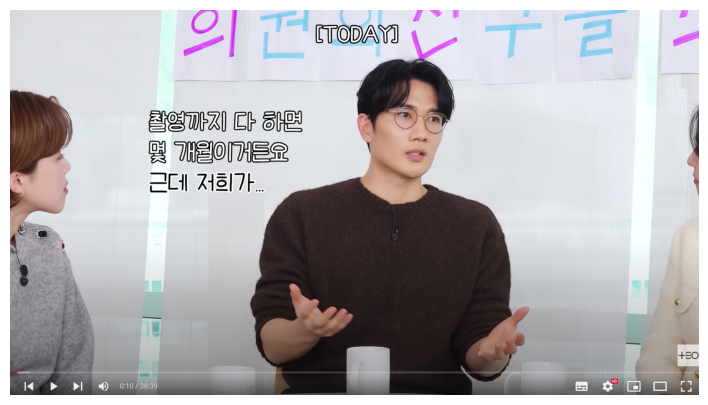

['{"Match Found": "Uhm Tae-goo", "Reasoning": "The person in the image has an oval face, wears thin rimmed rectangular glasses, has short black hair, and is wearing a brown sweater. This exactly matches the description provided for Uhm Tae-goo."}']

image_recognition/salon_drip_10.png


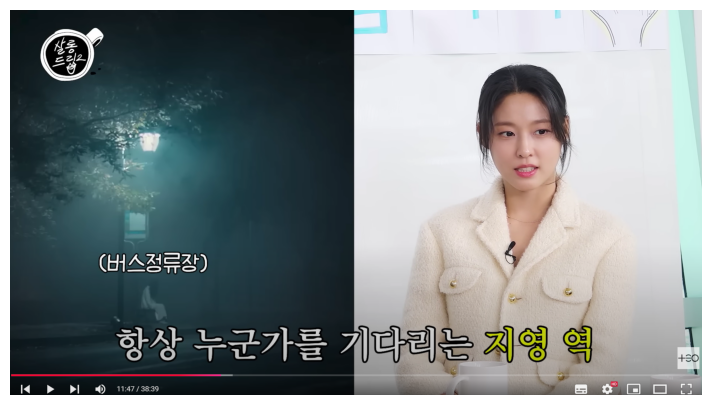

['{"Match Found": "Seolhyun", "Reasoning": "The woman in the image has an oval shaped face with slightly high cheekbones, almond-shaped eyes with well-defined eyebrows and dark lashes, and a small nose with a pointed tip, which matches Seolhyun\'s description. She is also wearing a white, tweed-like jacket with gold buttons and a gold necklace, and her hair is pulled back into a low, messy bun, which further confirms the match."}']

image_recognition/salon_drip_2.png


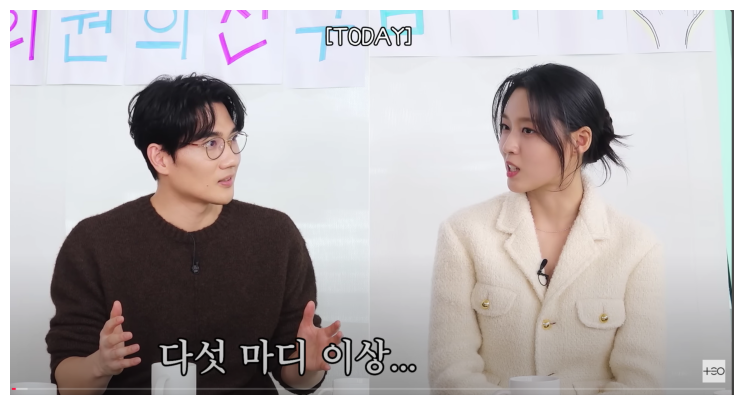

['{"Match Found": "Uhm Tae-goo", "Reasoning": "The man in the image has an oval face, wears thin rimmed rectangular glasses, has short black hair, and is wearing a brown sweater. These features match exactly with the description of Uhm Tae-goo."}', '{"Match Found": "Seolhyun", "Reasoning": "The woman in the image has an oval face, her long black hair is pulled back in a low bun and she is wearing a white tweed jacket. These features match exactly with the description of Seolhyun."}']

image_recognition/salon_drip_3.png


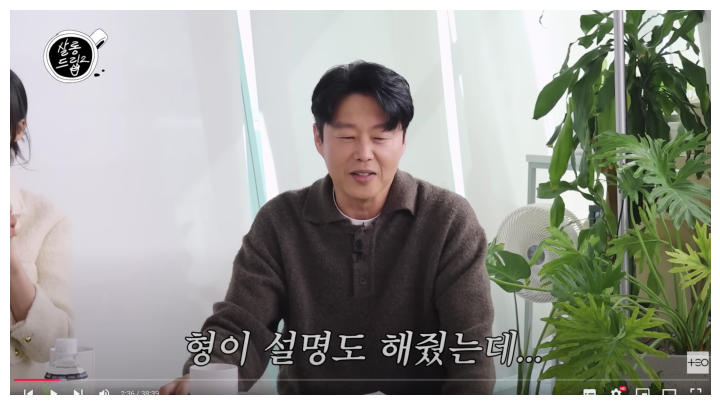

['{"Match Found": "Kim Hee-won", "Reasoning": "The man in the image has a round face, soft facial lines, a warm smile, slightly deep-set eyes, dark eyebrows, and short black hair, which matches the description of Kim Hee-won. He is also wearing a brown long-sleeved top, and his general demeanor matches the description of a gentle expression."}']

image_recognition/salon_drip_4.png


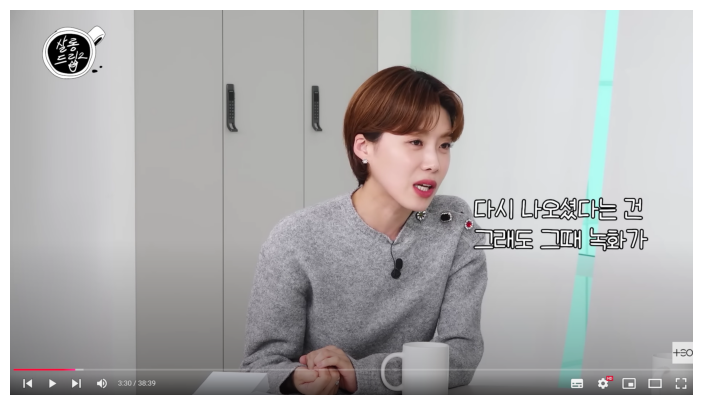

['{\n"Match Found": "Jang Doyeon",\n"Reasoning": "The person in the image has a round face, a wide smile, almond-shaped eyes with dark eyebrows and long lashes, a slightly upturned nose, and short, light brown hair in a rounded bob cut style. She is also wearing small stud earrings and a grey sweater, which is a match with the description of Jang Doyeon."\n}']

image_recognition/salon_drip_5.png


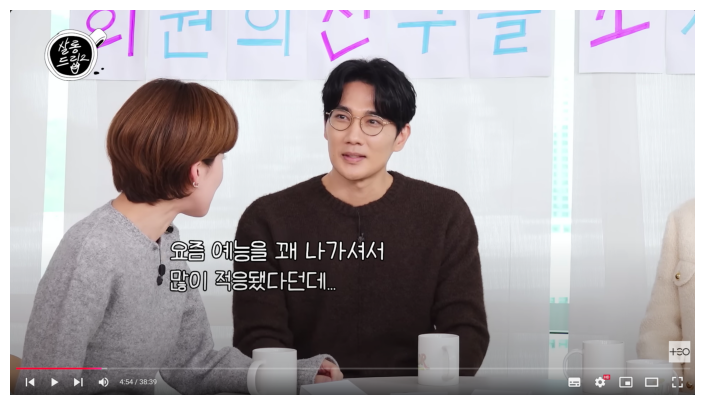

['{"Match Found": "Jang Doyeon", "Reasoning": "The woman on the left side of the image has a round face, short, light brown hair in a rounded bob style and is wearing a grey sweater. These features match the description for Jang Doyeon exactly."}', '{"Match Found": "Uhm Tae-goo", "Reasoning": "The man in the middle of the image has an oval face, short black hair, and is wearing glasses and a brown sweater. These features match the description for Uhm Tae-goo exactly."}']

image_recognition/salon_drip_6.png


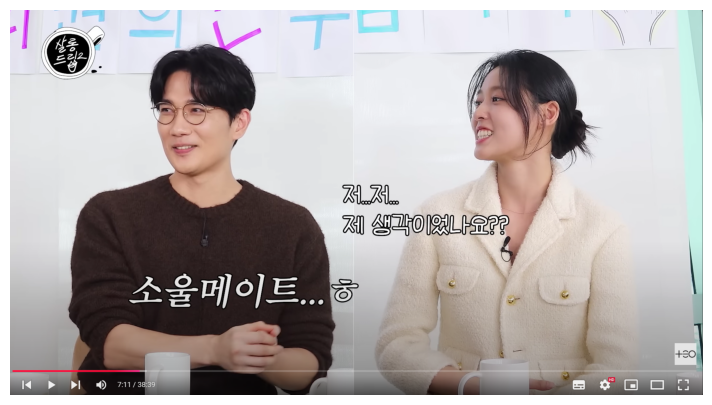

['{"Match Found": "Uhm Tae-goo", "Reasoning": "The man in the image has an oval face, wears rectangular thin rimmed glasses and a brown sweater. These traits match the description of Uhm Tae-goo, who is described with an oval face, wearing silver framed wire glasses which are rectangular in style, and wearing a simple brown sweater. The other individual in the image matches Seolhyun, with a round face and her long black hair is in a bun, also wearing a gold necklace and a white, tweed-like jacket with gold buttons. These traits are described for Seolhyun. Thus there is more than one match, but I am selecting the man on the left. The descriptions fit the individuals shown in the picture very well."}']

image_recognition/salon_drip_7.png


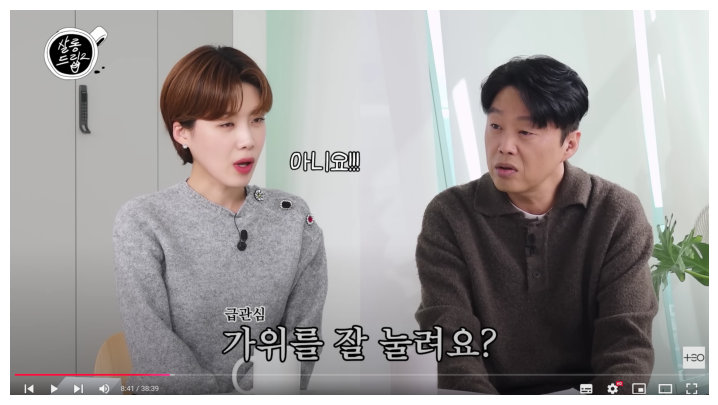

['{"Match Found": "Jang Doyeon", "Reasoning": "The woman in the image has a round face, a wide smile, almond-shaped eyes with dark eyebrows and long lashes, a slightly upturned nose, and short, light brown hair in a rounded bob cut, as well as stud earrings and a grey sweater with dark buttons. These all match the description of Jang Doyeon perfectly."}']

image_recognition/salon_drip_8.png


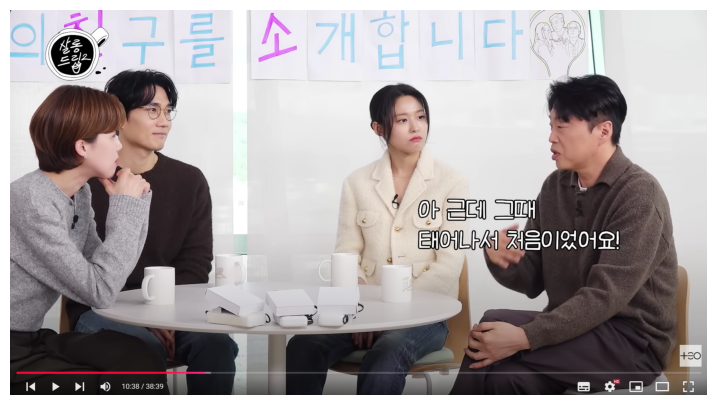

['{"Match Found": "Jang Doyeon", "Reasoning": "The person on the far left in the image matches the description of Jang Doyeon. She has a round face, short light brown hair with a rounded bob cut, and is wearing small stud earrings and a grey sweater. Her facial features match well with the description provided, including the almond shaped eyes, dark eyebrows, small nose, and bright smile. All of these elements match the given description perfectly."}', '{"Match Found": "Uhm Tae-goo", "Reasoning": "The person second from the left in the image matches the description of Uhm Tae-goo. He has an oval face with fair complexion, wears thin rimmed glasses that are rectangular, and has short black hair. His clothes matches the description with a simple brown sweater and dark jeans. All these elements match the given description perfectly."}', '{"Match Found": "Seolhyun", "Reasoning": "The person second from the right in the image matches the description of Seolhyun. She has an oval face, with l

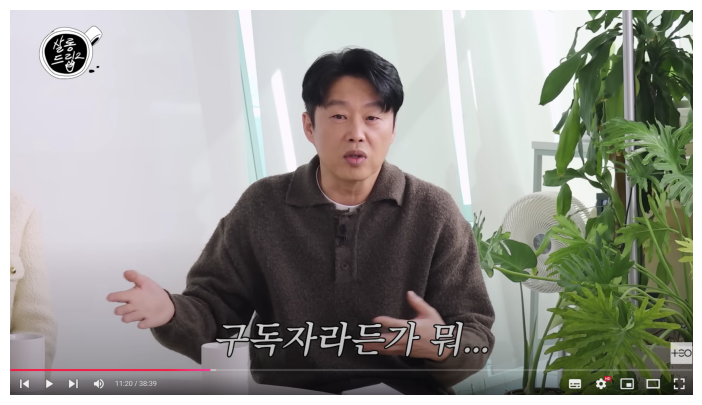

['{"Match Found": "Kim Hee-won", "Reasoning": "The person in the image has a round face, soft facial lines, and a warm smile, which matches the description of Kim Hee-won. He also has short, dark hair and is wearing a brown long-sleeved shirt, further confirming the match."}']



In [142]:
######## Video + Image At once
### Check Bucket(img) to run Loop
BUCKET_NAME = "jc-gcp-project-01"
FOLDER_NAME = "image_recognition"

# title_inf = "살롱드립2"

# Response schema
response_schema = {
                "type": "ARRAY",
                "items": {
                    "type": "STRING",
                },
            }

# List all blobs in the folder
blobs = bucket.list_blobs(prefix=FOLDER_NAME + '/')
for blob in blobs:
    if blob.name.startswith('image_recognition/salon_drip'):
        print(f"{blob.name}")
        image_file_uri = f"gs://{BUCKET_NAME}/{blob.name}"
        showImage(image_file_uri) # Show IMG
        
        # Prompt        
        prompt_transcript = f"""   
        You are a facial recognition expert. You will be provided with an image and a file containing descriptions of people's appearances. Your task is to analyze the image and find the person in the image whose appearance matches EXACTLY with one of the descriptions in the file.  Then, provide the name associated with that description.

        Follow these steps:

        1. Analyze the provided image: {image_file_uri}.
        2. Carefully review each description in the provided file: {character_desc}.
        3. Compare the facial features, hairstyle, and any other distinguishing characteristics visible in the image with the descriptions in the file.
        4. If you find a perfect match between the person in the image and a description exactly, provide the name associated with that description.  Explain the key features that led you to this conclusion.
        5. If you find multiple perfect matches, list all corresponding names. Explain the key features that led you to this conclusion.
        6. If the image quality is too poor to discern facial features or other identifying characteristics, respond with "Image quality is insufficient for identification."
        7. If no person in the image matches any of the descriptions in the file, respond with "No match found."

        Your response should be in the following format:

        * **Match Found:** [Name of the person]
        * **Reasoning:** [Explanation of the matching features]

        """
        
        
        
        json_str = generate_img(prompt_transcript, image_file_uri, response_schema) # Gemini Work
        json_transcript = json.loads(json_str)
        print(json_transcript)
        print()
        time.sleep(2)